In [1]:
import bz2
from collections import Counter
import os
import re

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [6]:
INDEX_FILE = "enwiki-20200901-pages-articles-multistream-index.txt.bz2"
DUMP_FILE = "enwiki-20200901-pages-articles-multistream.xml.bz2"

## PART 1: READ IN THE STREAM FILE AND GET THE START BYTES

In [7]:
with bz2.open(INDEX_FILE) as b:
    index_file_text = b.read()
index_file_text = index_file_text.decode()

In [8]:
index_file_lines = index_file_text.split("\n")
index_file_lines.pop(-1)
n_lines = len(index_file_lines)
new_stream_lines = [index_file_lines[l] for l in range(0, n_lines, 100)]

In [9]:
## Gather starting bytes.  Include the end of the file as one of the bytes; we'll
## handle that by iterating len(start_bytes) - 1 times when dealing with the file.
start_bytes = [int(x.split(":")[0]) for x in new_stream_lines]
file_size = os.path.getsize(DUMP_FILE)
start_bytes.append(file_size + 1)
len(start_bytes)

205611

## PART 2: SET UP REGEX CODE & FILTERS

In [10]:
def get_page_text(page_element):
    revision = page_element.find('revision')
    return revision.find('text').text

def get_page_name(page_element):
    return page_element.find('title').text

def is_redirect(page):
    return page.find("redirect") is not None

In [11]:
def filter_bad_pages(page_list):
    UNUSED_PAGE_PREFIXES = ["User:", "Wikipedia:", "User talk:", "Talk:", "Wikipedia talk:", "Template:",
                            "Help:", "MediaWiki:", "Help talk:", "MediaWiki talk:", "File:", "Category:",
                            "Template talk:", "Category talk:", "WT:", "US:", "CAT:", "T:", "MOS:",
                            "File talk:", "Module:", "H:"]
    
    page_list = [p for p in page_list if not is_redirect(p)]
    for prefix in UNUSED_PAGE_PREFIXES:
        page_list = [p for p in page_list if not get_page_name(p).startswith(prefix)]
    return page_list

In [13]:
months = ["January", "February", "March","April", "May", "June", "July", "August", "September", "October", "November", "December"]
month_day_year_words = re.compile(f"({'|'.join(months)})" + " ([0-9]{1,2})?(,)? [0-9]{4}")
day_month_year_words = re.compile("([0-9]{1,2}) " + f"({'|'.join(months)})" + "(,)? [0-9]{4}")
year_first_numbers = re.compile("[0-9]{4}[-/][0-9]{1,2}[-/][0-9]{1,2}")
year_last_numbers = re.compile("[0-9]{1,2}[-/][0-9]{1,2}[-/][0-9]{4}")
times = re.compile("([0-2]?[0-9]:[0-5][0-9])( AM| PM)?")
month_day_words = re.compile(f"({'|'.join(months)})" + " [0-9]{1,2}")
day_month_words = re.compile("[0-9]{1,2} " + f"({'|'.join(months)})")

In [14]:
def remove_dates_and_times(page_text):
    page_text = re.sub(month_day_year_words, "", page_text)
    page_text = re.sub(day_month_year_words, "", page_text)
    page_text = re.sub(month_day_words, "", page_text)
    page_text = re.sub(day_month_words, "", page_text)
    page_text = re.sub(year_first_numbers, "", page_text)
    page_text = re.sub(year_last_numbers, "", page_text)
    page_text = re.sub(times, "", page_text)
    return page_text

In [15]:
def remove_lone_years(page_text):
    page_text = re.sub("[Ii]n [12][0-9]{3}", "", page_text)
    page_text = re.sub("[12][0-9]{3}(-| to )[12][0-9]{3}", "", page_text)
    page_text = re.sub("[Ff]rom [12][0-9]{3}", "", page_text)
    page_text = re.sub("\([12][0-9]{3}\)", "", page_text)
    return page_text

In [ ]:
def remove_all_years(page_text):
    page_text = re.sub("1[0-9]{3}", "", page_text)
    page_text = re.sub("20[0-9][0-9]", "", page_text)

In [16]:
def get_numbers_from_page(page_text):
    numbers = re.findall("[0-9.,]{1,}", page_text)
    numbers = [n.lstrip("0.,") for n in numbers if re.search("[1-9]", n)]
    return numbers

In [17]:
def get_first_digits_from_page(page_text):
    numbers = re.findall("[0-9.,]{1,}", page_text)
    numbers = [n.lstrip("0.,")[0] for n in numbers if re.search("[1-9]", n)]
    return Counter(numbers)

In [18]:
def remove_non_text(page_text):
    page_text = re.sub("\[\[File:.*?\]\]", "", page_text)
    page_text = re.sub("\[\[Image:.*?\]\]", "", page_text)
    page_text = re.sub("{{.*?}}", "", page_text)
    return page_text

## PART 3: EXTRACT A STREAM

In [45]:
benford1 = Counter({str(i):0 for i in range(1,10)})
benford2 = Counter({str(i):0 for i in range(1,10)})
benford3 = Counter({str(i):0 for i in range(1,10)})
benford_df = pd.DataFrame()

stream_file = open(DUMP_FILE, "rb")

for i in tqdm(range(len(start_bytes)-1)):
    decomp = bz2.BZ2Decompressor()
    stream_file.seek(start_bytes[i])
    readback = stream_file.read(start_bytes[i+1] - start_bytes[i] - 1)
    page_xml = decomp.decompress(readback).decode()
    
    soup = BeautifulSoup(page_xml)
    page_list = filter_bad_pages(soup.find_all("page"))
    page_texts = [get_page_text(p) for p in page_list]
    
    for pt in page_texts:
        try:
            count1 = get_first_digits_from_page(pt)
            
            pt = remove_non_text(pt)
            pt = remove_dates_and_times(pt)
            
            pt_no_lone_years = remove_lone_years(pt)
            count2 = get_first_digits_from_page(pt_no_lone_years)
            
            pt = remove_all_years(pt)
            count3 = get_first_digits_from_page(pt)
            
            benford1 = benford1 + count1
            benford2 = benford2 + count2
            benford3 = benford3 + count3
        except:
            pass
    
    if (i+1) % 100 == 0:
        new_row = {}
        for i, b in enumerate([benford1, benford2, benford3]):
            for k in b.keys():
                new_row[f"{i}_{k}"] = b[k]
        benford_df = benford_df.append(new_row, ignore_index=True)
        benford1 = Counter({str(i):0 for i in range(1,10)})
        benford2 = Counter({str(i):0 for i in range(1,10)})
        benford3 = Counter({str(i):0 for i in range(1,10)})
    
stream_file.close()

100%|██████████| 205610/205610 [9:12:10<00:00,  6.21it/s]   


In [48]:
## add final round
new_row = {}
for i, b in enumerate([benford1, benford2, benford3]):
    for k in b.keys():
        new_row[f"{i}_{k}"] = b[k]
benford_df = benford_df.append(new_row, ignore_index=True)

In [6]:
benford_df.to_csv("benford_counts.csv")

TypeError: to_csv() got an unexpected keyword argument 'index_col'

### PROCESSING THE CSV

In [19]:
benford_df = pd.read_csv("benford_counts.csv", index_col=0)

In [20]:
col_sums = benford_df.sum()

case1_sums = col_sums[0:9].values
case2_sums = col_sums[9:18].values
case3_sums = col_sums[18:].values

case1_percents = 100 * case1_sums/sum(case1_sums)
case2_percents = 100 * case2_sums/sum(case2_sums)
case3_percents = 100 * case3_sums/sum(case3_sums)

In [69]:
print(case1_sums.sum())
print(case2_sums.sum())
print(case3_sums.sum())

803350230.0
405844709.0
325389290.0


In [65]:
x = np.arange(1,10)
benford_theoretical = 100*np.log10(1 + 1/x)

In [67]:
pd.DataFrame({"Theoretical":benford_theoretical,
              "AllNumbers":case1_percents,
              "ReasonableCheck":case2_percents,
              "AllPossibleYears":case3_percents})

,Theoretical,AllNumbers,ReasonableCheck,AllPossibleYears
0,30.103000,34.192143,36.058390,29.482770
1,17.609126,32.973080,26.196379,21.848295
2,12.493874,8.167111,9.430543,12.035884
3,9.691001,5.677718,6.764181,8.699148
4,7.918125,4.650655,5.271394,6.833022
5,6.694679,3.979152,4.864455,6.267823
6,5.799195,3.413108,3.900330,5.060124
7,5.115252,3.461403,3.739848,4.861015
8,4.575749,3.485631,3.774479,4.911918


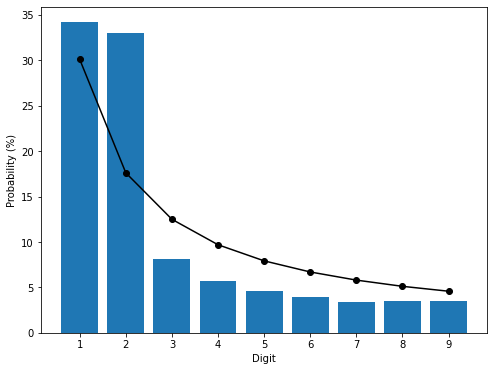

In [58]:
plt.bar(x, case1_percents)
plt.plot(x, benford_theoretical, color="black", marker="o")
plt.xlabel("Digit")
plt.xticks(x)
plt.ylabel("Probability (%)")
fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.savefig('case1.png')

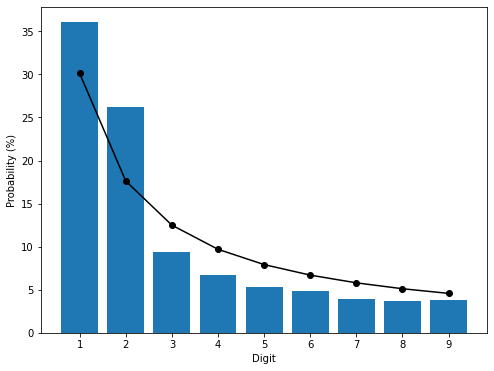

In [59]:
plt.bar(x, case2_percents)
plt.plot(x, benford_theoretical, color="black", marker="o")
plt.xlabel("Digit")
plt.xticks(x)
plt.ylabel("Probability (%)")
fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.savefig('case2.png')

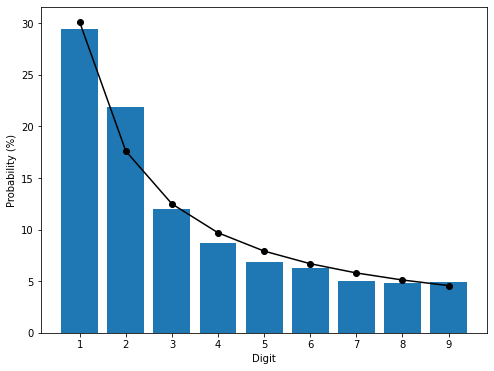

In [60]:
plt.bar(x, case3_percents)
plt.plot(x, benford_theoretical, color="black", marker="o")
plt.xlabel("Digit")
plt.xticks(x)
plt.ylabel("Probability (%)")
fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.savefig('case3.png')